# Dự đoán độ hiệu quả khóa học
Trong notebook này, chúng ta sẽ xây dựng mô hình dự đoán độ hiệu quả khóa học trong MOOCCubeX chỉ dựa trên 1 số thông tin cơ bản (bảng course.json).





# 1. Download and import libraries

In [1]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... - \ | done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17395 sha256=49e0ff5b927269a4e44d035926cf17e2a4aa3aba5d8a9178cd53b6a73609c09b
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import warnings
import json
import shutil
import pickle
import time
from googletrans import Translator

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

In [4]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.0
    Uninstalling ml_dtypes-0.5.0:
      Successfully uninstalled ml_dtypes-0.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.4.35 requires ml-dtypes>=0.4.0, but you have ml-dtypes 0.3.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Bidirectional, LSTM, concatenate
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
warnings.filterwarnings('ignore')

## 2. Get dataset

In [7]:
import pandas as pd

# Đọc các file
course_json = "/kaggle/input/mooccubex-dataset/course.json"
course_1000 = "/kaggle/input/1000course/top_1000_courses.csv"
label_3_file = "/kaggle/input/tieuchi4/nhan 4.csv"
label_4_file = "/kaggle/input/labeled-course/labeled_courses.csv"
label_1_file = "/kaggle/input/nhan-2/labeled_1_course_with_labels.csv"
label_2_file = "/kaggle/input/tieu-chi-2/label3_course.csv"

# Đọc các bảng dữ liệu
course_df = pd.read_json(course_json, lines= True)
course_1000_df = pd.read_csv(course_1000)
label_3_df = pd.read_csv(label_3_file)
label_4_df = pd.read_csv(label_4_file)
label_1_df = pd.read_csv(label_1_file)
label_2_df = pd.read_csv(label_2_file)

In [8]:
course_1000_df.head(5)

,course_order
0,936971
1,696994
2,676932
3,697791
4,883345


In [9]:
label_1_df.head(5)

,Course_ID,avg_score_course
0,680963,3
1,694149,3
2,697293,3
3,696994,3
4,697791,3


In [10]:
label_2_df.head(5)

,course_id,new_label
0,C_1159827,4.0
1,C_1410156,3.0
2,C_1428968,3.0
3,C_1429002,2.0
4,C_1434593,4.0


In [11]:
label_3_df.head(5)

,Course_ID,challenge_index
0,936971,2
1,696994,2
2,676932,2
3,697791,2
4,883345,2


In [12]:
label_4_df.head(5)

,course_id,course_score
0,C_1011639,3.0
1,C_1017355,4.0
2,C_1159827,3.0
3,C_1196947,3.0
4,C_1214863,3.0


In [13]:
import pandas as pd

# Chuyển đổi cột `Course_ID` và `course_id` thành kiểu chuỗi để đảm bảo kết hợp được
course_1000_df['course_order'] = course_1000_df['course_order'].astype(str)
label_1_df['Course_ID'] = label_1_df['Course_ID'].astype(str)
label_2_df['course_id'] = label_2_df['course_id'].astype(str)
label_3_df['Course_ID'] = label_3_df['Course_ID'].astype(str)
label_4_df['course_id'] = label_4_df['course_id'].astype(str)

# Loại bỏ khoảng trắng thừa (nếu có) trong các cột 'course_order' và 'Course_ID'
course_1000_df['course_order'] = course_1000_df['course_order'].str.strip()
label_1_df['Course_ID'] = label_1_df['Course_ID'].str.strip()
label_2_df['course_id'] = label_2_df['course_id'].str.strip()
label_3_df['Course_ID'] = label_3_df['Course_ID'].str.strip()
label_4_df['course_id'] = label_4_df['course_id'].str.strip()

# Thêm tiền tố 'C_' nếu thiếu trong `Course_ID` (cho label_1_df và label_3_df)
course_1000_df['course_order'] = course_1000_df['course_order'].apply(lambda x: f"C_{x}" if not x.startswith('C_') else x)
label_1_df['Course_ID'] = label_1_df['Course_ID'].apply(lambda x: f"C_{x}" if not x.startswith('C_') else x)
label_3_df['Course_ID'] = label_3_df['Course_ID'].apply(lambda x: f"C_{x}" if not x.startswith('C_') else x)

# Kết hợp các bảng
combined_df = pd.merge(course_1000_df, label_1_df[['Course_ID', 'avg_score_course']], 
                       left_on='course_order', right_on='Course_ID', how='left')

combined_df = pd.merge(combined_df, label_3_df[['Course_ID', 'challenge_index']], 
                       left_on='course_order', right_on='Course_ID', how='left')

combined_df = pd.merge(combined_df, label_4_df[['course_id', 'course_score']], 
                       left_on='course_order', right_on='course_id', how='left')

combined_df = pd.merge(combined_df, label_2_df[['course_id', 'new_label']], 
                       left_on='course_order', right_on='course_id', how='left')

# Đổi tên các cột nhãn để dễ đọc
combined_df.rename(columns={
    'course_order': 'course_id',
    'avg_score_course': '1. avg_score',
    'challenge_index': '3. challenge_index',
    'course_score': '4. sentiment_index',
    'new_label': '2. video_habit'
}, inplace=True)

# Lọc lại các cột cần thiết và hiển thị kết quả
combined_df = combined_df[['course_id', '1. avg_score', '2. video_habit', '3. challenge_index', '4. sentiment_index']]

# Điền giá trị 0 cho tất cả các ô trống trong DataFrame nếu cần
combined_df.fillna(0, inplace=True)

# Hiển thị kết quả
combined_df.head()

,course_id,1. avg_score,2. video_habit,3. challenge_index,4. sentiment_index
0,C_936971,3,1.0,2,3.0
1,C_696994,3,0.0,2,4.0
2,C_676932,3,0.0,2,3.0
3,C_697791,3,3.0,2,3.0
4,C_883345,3,2.0,2,3.0


In [14]:
combined_df.to_csv("/kaggle/working/combined_df.csv")

In [15]:
course_df

,id,name,field,prerequisites,about,resource
0,C_584313,《资治通鉴》导读,"[历史学, 中国语言文学]",,通过老师导读，同学们可深入这一经典文本内部，得以纵览千年历史，提升国学素养，体味人生智慧。,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso..."
1,C_584329,微积分——极限理论与一元函数,"[应用经济学, 数学, 物理学, 理论经济学]",,本课程是理工科的一门数学基础课，系统、全面地介绍了一元函数微积分学。课程既保持了数学的严谨和...,"[{'titles': ['序言', '序言', '序言'], 'resource_id':..."
2,C_584381,新闻摄影,"[艺术学, 新闻传播学]",,掌握基本的摄影技能，了解图片新闻的工作方式，训练对生活的观察和热爱，发展对图像的审美和批评能...,"[{'titles': ['第一章 绪论', '第一讲 引言1', '引言1'], 'res..."
3,C_597208,数据挖掘：理论与算法,[计算机科学与技术],,最有趣的理论+最有用的算法=不得不学的数据科学。,"[{'titles': ['走进数据科学：博大精深，美不胜收', '整装待发', 'Vide..."
4,C_597225,大学计算机,[],,大学计算机课程将以计算思维为导向，以计算机原理、概念为基础，以新技术新方法为牵引，以创新思维...,"[{'titles': ['第1周： 基于计算机的问题求解', '课程介绍', '开篇'],..."
...,...,...,...,...,...,...
3776,C_2338076,（疾风计划）软件工程,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第1章 初识软件工程 ', '1.1 软件无处不在 ', '讲课..."
3777,C_2341259,（疾风计划）面向对象程序设计（C++）,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第一讲 课程简介与编程环境', '1.0 课程定位、教学内容',..."
3778,C_2337996,（疾风计划）数据结构(下),[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第零章 ', '选课之前', '宣传片'], 'resourc..."
3779,C_1945689,机器学习训练营,[],,清华张敏老师带你12周掌握机器学习！8大经典算法 +7大实训 + 直播点评 + 博士助教+云...,"[{'titles': ['序-开营仪式及学习课件', None, '1.1_初识机器学习'..."


In [16]:
import pandas as pd

# Đảm bảo cột 'id' được đổi tên thành 'course_id' trong DataFrame course_json
course_df =  course_df.rename(columns={'id': 'course_id'})

# Kiểm tra các cột trong df_course và df_course_rate trước khi merge
print("Các cột trong df_course:", course_df.columns)
print("Các cột trong df_course_rate:", combined_df.columns)

# Kết hợp df_course và df_course_rate dựa trên cột 'course_id'
df = pd.merge(course_df, combined_df, on='course_id', how='inner')  # Dùng 'inner' để chỉ lấy các khóa học trùng nhau
df.head()

Các cột trong df_course: Index(['course_id', 'name', 'field', 'prerequisites', 'about', 'resource'], dtype='object')
Các cột trong df_course_rate: Index(['course_id', '1. avg_score', '2. video_habit', '3. challenge_index',
       '4. sentiment_index'],
      dtype='object')


,course_id,name,field,prerequisites,about,resource,1. avg_score,2. video_habit,3. challenge_index,4. sentiment_index
0,C_674903,不朽的艺术：走进大师与经典,[艺术学],无,【国家精品课】以历史为经线，中外比较为纬线，以文化解读为主导，引导修课学生欣赏和理解中西艺术...,"[{'titles': ['第一讲：艺术概说：问题与方法', ' 1.图像与信息：事实缺损'...",3,0.0,2,4.0
1,C_674910,图案审美与创作,[],,【国家精品课】本课程提供图案感受美、提炼美、表现美的过程体验。学习图案可以了解历史，感受时代...,"[{'titles': ['第一讲 图案导学1', '1-1图案与时尚、历史、文化等', '...",3,0.0,2,4.0
2,C_674912,音乐与健康,[],,本课程精心设计了音乐与健康、治疗、养生、音乐处方单等八个专题的内容，适合喜爱音乐和关注身心健...,"[{'titles': ['1 音乐与健康', '1.1 导论', '导论'], 're...",2,0.0,2,4.0
3,C_674914,管理会计学,[],,本课程顺应新经济发展趋势，主要讲述了管理会计基础理论和实际运用方法，旨在为学员搭建起管理会计...,"[{'titles': ['第一章 总论', '1.1管理会计的基本概念和内容', '1.1...",3,0.0,4,3.0
4,C_674920,逻辑学概论,[哲学],,“逻辑”是什么？大家都很熟悉却又似乎难以说清。本课程将告诉你：作为一门学科，逻辑学研究的是什...,"[{'titles': ['第一讲 什么是逻辑学', '1.1 “逻辑""和逻辑学', '默认...",3,4.0,2,3.0


In [17]:
import pandas as pd
import numpy as np

# Hàm tính trung bình các nhãn với trọng số (loại trừ giá trị 0)
def calculate_effectiveness(row):
    # Trọng số cho từng nhãn
    weights = [2, 2, 1, 5]  # Tương ứng với '1. avg_score', '2. video_habit', '3. challenge_index', '4. sentiment_index'
    labels = [row['1. avg_score'], row['2. video_habit'], row['3. challenge_index'], row['4. sentiment_index']]
    
    # Loại bỏ nhãn bằng 0
    valid_labels = [(label, weight) for label, weight in zip(labels, weights) if label != 0]
    
    if valid_labels:  # Nếu có nhãn hợp lệ
        # Tính tổng có trọng số
        weighted_sum = sum(label * weight for label, weight in valid_labels)
        # Tính tổng trọng số
        total_weight = sum(weight for _, weight in valid_labels)
        # Tính trung bình trọng số
        return weighted_sum / total_weight
    
    return 0  # Nếu tất cả đều bằng 0 thì trả về 0

# Tạo nhãn mới 'effectiveness' và làm tròn giá trị
df['effectiveness'] = df.apply(calculate_effectiveness, axis=1).round(0)

# Xem trước kết quả
df[['1. avg_score', '2. video_habit', '3. challenge_index', '4. sentiment_index', 'effectiveness']].head()

,1. avg_score,2. video_habit,3. challenge_index,4. sentiment_index,effectiveness
0,3,0.0,2,4.0,4.0
1,3,0.0,2,4.0,4.0
2,2,0.0,2,4.0,3.0
3,3,0.0,4,3.0,3.0
4,3,4.0,2,3.0,3.0


In [18]:
df.head(5)

,course_id,name,field,prerequisites,about,resource,1. avg_score,2. video_habit,3. challenge_index,4. sentiment_index,effectiveness
0,C_674903,不朽的艺术：走进大师与经典,[艺术学],无,【国家精品课】以历史为经线，中外比较为纬线，以文化解读为主导，引导修课学生欣赏和理解中西艺术...,"[{'titles': ['第一讲：艺术概说：问题与方法', ' 1.图像与信息：事实缺损'...",3,0.0,2,4.0,4.0
1,C_674910,图案审美与创作,[],,【国家精品课】本课程提供图案感受美、提炼美、表现美的过程体验。学习图案可以了解历史，感受时代...,"[{'titles': ['第一讲 图案导学1', '1-1图案与时尚、历史、文化等', '...",3,0.0,2,4.0,4.0
2,C_674912,音乐与健康,[],,本课程精心设计了音乐与健康、治疗、养生、音乐处方单等八个专题的内容，适合喜爱音乐和关注身心健...,"[{'titles': ['1 音乐与健康', '1.1 导论', '导论'], 're...",2,0.0,2,4.0,3.0
3,C_674914,管理会计学,[],,本课程顺应新经济发展趋势，主要讲述了管理会计基础理论和实际运用方法，旨在为学员搭建起管理会计...,"[{'titles': ['第一章 总论', '1.1管理会计的基本概念和内容', '1.1...",3,0.0,4,3.0,3.0
4,C_674920,逻辑学概论,[哲学],,“逻辑”是什么？大家都很熟悉却又似乎难以说清。本课程将告诉你：作为一门学科，逻辑学研究的是什...,"[{'titles': ['第一讲 什么是逻辑学', '1.1 “逻辑""和逻辑学', '默认...",3,4.0,2,3.0,3.0


In [19]:
df.to_csv("/kaggle/working/df.csv")

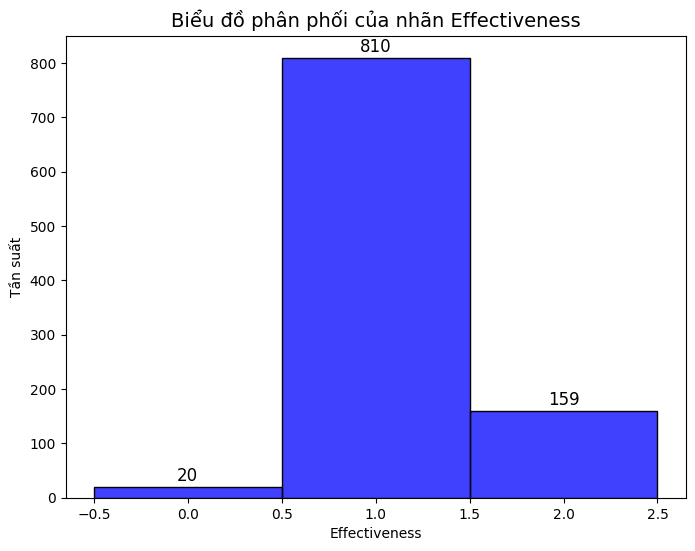

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập kích thước của biểu đồ
plt.figure(figsize=(8, 6))

# Vẽ biểu đồ phân phối sử dụng seaborn
df['effectiveness'] = df['effectiveness'].replace(5, 4)
# Chuyển nhãn 2 thành 1, 3 thành 2, và 4 thành 3
df['effectiveness'] = df['effectiveness'].replace({2: 0, 3: 1, 4: 2})
ax = sns.histplot(df['effectiveness'], color='blue', discrete=True)

# Thêm tiêu đề và nhãn cho các trục
plt.title('Biểu đồ phân phối của nhãn Effectiveness', fontsize=14)
plt.xlabel('Effectiveness')
plt.ylabel('Tần suất')

# Thêm số lượng ở mỗi nhãn
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 8), textcoords='offset points')

# Hiển thị biểu đồ
plt.show()

## 3. Split dataset

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# Giả sử df là DataFrame chứa dữ liệu của bạn
# df['effectiveness'] là nhãn mục tiêu

# Tạo cột 'text' là tổ hợp 'name' và 'about'
df['about'] = df['about'].fillna("")  # Xử lý NaN
df['text'] = df['name'] + ' ' + df['about']

# Chia dữ liệu thành X và y
X = df['text']  # Cột 'text' (tổ hợp 'name' + 'about')
y = df['effectiveness']  # Cột 'effectiveness'

# Chuyển đổi dữ liệu văn bản thành các đặc trưng số
vectorizer = TfidfVectorizer(max_features=1000)  # Giới hạn số đặc trưng để giảm độ phức tạp
X_tfidf = vectorizer.fit_transform(X)

# Chia dữ liệu thành tập huấn luyện và kiểm tra với tỷ lệ 80:20, đảm bảo tỉ lệ các nhãn
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Kiểm tra sự phân bố của các lớp trong dữ liệu huấn luyện
print("Class distribution in y_train:", Counter(y_train))

# Các mô hình
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier()
}

# Bước 3: Huấn luyện và đánh giá các mô hình
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    
    # Dự đoán nhãn 'effectiveness' trên tập kiểm tra
    y_pred = model.predict(X_test)
    
    # Đánh giá hiệu suất mô hình
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # In kết quả
    print(f"Accuracy for {model_name}: {accuracy * 100:.2f}%")
    print(f"Classification Report for {model_name}:")
    print(class_report)
    print(f"Confusion Matrix for {model_name}:")
    print(conf_matrix)
    print("-" * 50)

Class distribution in y_train: Counter({1.0: 648, 2.0: 127, 0.0: 16})
Training and evaluating Logistic Regression...
Accuracy for Logistic Regression: 82.32%
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.82      1.00      0.90       162
         2.0       1.00      0.03      0.06        32

    accuracy                           0.82       198
   macro avg       0.61      0.34      0.32       198
weighted avg       0.83      0.82      0.75       198

Confusion Matrix for Logistic Regression:
[[  0   4   0]
 [  0 162   0]
 [  0  31   1]]
--------------------------------------------------
Training and evaluating Random Forest...
Accuracy for Random Forest: 79.80%
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.82      0.97      0.89      

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Giả sử df là dữ liệu của bạn đã có nhãn 'effectiveness'
df2 = df.copy()

# Xử lý dữ liệu NaN và kết hợp các cột
df2['about'] = df2['about'].fillna("")
df2['text'] = df2['name'] + ' ' + df2['about']

# Xác định X và y
X = df2['text']  # Cột 'text'
y = df2['effectiveness']  # Cột 'effectiveness'

# Chuyển đổi văn bản thành đặc trưng số
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(X)

# Chia dữ liệu thành tập huấn luyện và kiểm tra (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Kiểm tra sự phân bố của các lớp trong dữ liệu huấn luyện
print("Class distribution in y_train before SMOTE:", Counter(y_train))

# Sử dụng RandomOverSampler thay vì SMOTE để chỉ tăng lớp thiểu số
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Kiểm tra lại sự phân bố lớp sau khi sử dụng RandomOverSampler
print("Class distribution in y_train after RandomOverSampler:", Counter(y_train_res))

# Các mô hình và tham số để giảm mất cân bằng
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', C=1),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10),
    'SVM': SVC(class_weight='balanced', C=1, kernel='linear'),
    'XGBoost': XGBClassifier(scale_pos_weight=1, max_depth=6, n_estimators=100)
}

# Huấn luyện và đánh giá các mô hình
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    
    # Huấn luyện mô hình
    model.fit(X_train_res, y_train_res)
    
    # Dự đoán nhãn trên tập kiểm tra
    y_pred = model.predict(X_test)
    
    # Đánh giá hiệu suất mô hình
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # In kết quả
    print(f"Accuracy for {model_name}: {accuracy * 100:.2f}%")
    print(f"Classification Report for {model_name}:")
    print(class_report)
    print(f"Confusion Matrix for {model_name}:")
    print(conf_matrix)
    print("-" * 50)

Class distribution in y_train before SMOTE: Counter({1.0: 649, 2.0: 127, 0.0: 15})
Class distribution in y_train after RandomOverSampler: Counter({1.0: 649, 2.0: 649, 0.0: 649})
Training and evaluating Logistic Regression...
Accuracy for Logistic Regression: 76.26%
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.82      0.92      0.87       161
         2.0       0.19      0.09      0.12        32

    accuracy                           0.76       198
   macro avg       0.34      0.34      0.33       198
weighted avg       0.70      0.76      0.72       198

Confusion Matrix for Logistic Regression:
[[  0   4   1]
 [  1 148  12]
 [  0  29   3]]
--------------------------------------------------
Training and evaluating Random Forest...
Accuracy for Random Forest: 79.29%
Classification Report for Random Forest:
              precision    recall  f1-score   supp

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Giả sử df là dữ liệu của bạn đã có nhãn 'effectiveness'
df2 = df.copy()

# Xử lý dữ liệu NaN và kết hợp các cột
df2['about'] = df2['about'].fillna("")
df2['text'] = df2['name'] + ' ' + df2['about']

# Xác định X và y
X = df2['text']  # Cột 'text'
y = df2['effectiveness']  # Cột 'effectiveness'

# Chuyển đổi văn bản thành đặc trưng số
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(X)

# Chia dữ liệu thành tập huấn luyện và kiểm tra (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Kiểm tra sự phân bố của các lớp trong dữ liệu huấn luyện
print("Class distribution in y_train before balancing:", Counter(y_train))

# Kỹ thuật undersampling + oversampling
# 1. RandomUnderSampler giảm lớp chiếm ưu thế
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# 2. RandomOverSampler tăng lớp thiểu số
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Kết hợp cả hai kỹ thuật
pipeline = Pipeline(steps=[('under', under_sampler), ('over', over_sampler)])

# Áp dụng kỹ thuật undersampling và oversampling cho bộ dữ liệu huấn luyện
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

# Kiểm tra lại sự phân bố lớp sau khi sử dụng undersampling + oversampling
print("Class distribution in y_train after balancing:", Counter(y_train_res))

# Các mô hình và tham số để giảm mất cân bằng
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', C=1),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10),
    'SVM': SVC(class_weight='balanced', C=1, kernel='linear'),
    'XGBoost': XGBClassifier(scale_pos_weight=1, max_depth=6, n_estimators=100)
}

# Huấn luyện và đánh giá các mô hình
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    
    # Huấn luyện mô hình
    model.fit(X_train_res, y_train_res)
    
    # Dự đoán nhãn trên tập kiểm tra
    y_pred = model.predict(X_test)
    
    # Đánh giá hiệu suất mô hình
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # In kết quả
    print(f"Accuracy for {model_name}: {accuracy * 100:.2f}%")
    print(f"Classification Report for {model_name}:")
    print(class_report)
    print(f"Confusion Matrix for {model_name}:")
    print(conf_matrix)
    print("-" * 50)

Class distribution in y_train before balancing: Counter({1.0: 649, 2.0: 127, 0.0: 15})
Class distribution in y_train after balancing: Counter({0.0: 15, 1.0: 15, 2.0: 15})
Training and evaluating Logistic Regression...
Accuracy for Logistic Regression: 17.17%
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.11      0.20      0.14         5
         1.0       1.00      0.01      0.02       161
         2.0       0.17      0.97      0.28        32

    accuracy                           0.17       198
   macro avg       0.43      0.39      0.15       198
weighted avg       0.84      0.17      0.07       198

Confusion Matrix for Logistic Regression:
[[  1   0   4]
 [  7   2 152]
 [  1   0  31]]
--------------------------------------------------
Training and evaluating Random Forest...
Accuracy for Random Forest: 16.67%
Classification Report for Random Forest:
              precision    recall  f1-score   support

  

## 4. Build model

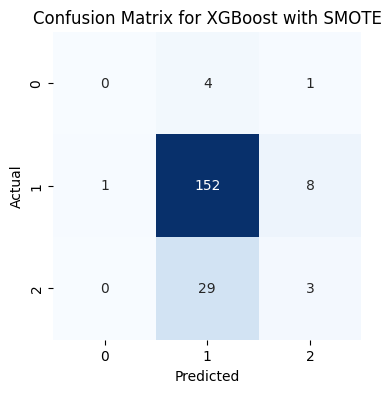

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion Matrix cho kết quả XGBoost sử dụng SMOTE
conf_mat = np.array([[0, 4, 1], 
                     [1, 152, 8], 
                     [0, 29, 3]])

# Vẽ biểu đồ confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_mat, annot=True, fmt=".0f", square=True, cmap='Blues', cbar=False)

# Thêm các nhãn và tiêu đề cho biểu đồ
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for XGBoost with SMOTE')

# Hiển thị biểu đồ
plt.show()

**Nhận xét:** Do input của mô hình này còn khá hạn chế, nguồn dữ liệu cũng nhỏ chỉ 1000 khóa học (1000 dòng) nên kết quả mô hình dự đoán không cao, nhưng với 0.XX precision,... kết quả dự đoán được xem là khá ổn. Điểm yếu lớn nhất của bài toán này là do dữ liệu đầu vào ít ỏi và mất cân bằng nghiêm trọng, nên dù đã sử dụng các kĩ thuật xử lý thì vẫn ... Hiệu xuất của bài toán có thể được nâng cao nếu thực hiện làm đa dạng thêm các biến đầu vào, làm giàu dữ liệu, mở rộng phạm vi bộ dữ liệu, cải thiện mô hình, tinh chính tham số,....